In [1]:
import itertools
import numpy as np
import os
import seaborn as sns
from tqdm import tqdm
from dataclasses import asdict, dataclass, field
import vsketch
import shapely.geometry as sg
from shapely.geometry import box, MultiLineString, Point, MultiPoint, Polygon, MultiPolygon, LineString
import shapely.affinity as sa
import shapely.ops as so
import matplotlib.pyplot as plt
import pandas as pd

import vpype_cli
from typing import List, Generic
from genpen import genpen as gp, utils as utils
from scipy import stats as ss
import geopandas
from shapely.errors import TopologicalError
import functools
%load_ext autoreload
%autoreload 2
import vpype
from skimage import io
from pathlib import Path

import bezier

from sklearn.preprocessing import minmax_scale
from skimage import feature
from genpen.utils import Paper

from scipy import spatial, stats
from scipy.ndimage import gaussian_filter
from scipy.integrate import odeint
from functools import partial

from genpen.grower import *
import fn
from genpen.axicam import AxiCam

from sklearn.preprocessing import minmax_scale
from skimage import feature
from skimage import exposure

from skimage import filters
from skimage.color import rgb2gray
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.morphology import disk

def local_angle(dx, dy):
    """Calculate the angles between horizontal and vertical operators."""
    return np.mod(np.arctan2(dy, dx), np.pi)

from PIL import Image


import cv2


In [2]:
# make page
paper_size = '11x14 inches'
border:float=20
paper = Paper(paper_size)

drawbox = paper.get_drawbox(border)

In [3]:
(xbins, ybins), (xs, ys) = gp.overlay_grid(poly=drawbox, xstep=3, ystep=3, flatmesh=True)

In [4]:
pts = [Point(x, y) for x,y in zip(xs, ys)]

In [5]:
T_x = 0.045
T_y = 0.33
radius = 6

In [6]:
rpolys = []
for ii, pt in enumerate(pts):
    angle = np.cos(T_x * pt.x) + np.sin(T_y * pt.y**0.5)
    poly = gp.RegPolygon(
        pt,
        radius=radius,
        n_corners=4,
        rotation=np.degrees(angle),
    )
    rpolys.append(poly.poly)

In [7]:
polys = gp.merge_Polygons(rpolys)

In [8]:
lss = polys.boundary

In [9]:
sk = vsketch.Vsketch()
sk.size(paper.page_format_mm)
sk.scale('1mm')
sk.penWidth('0.3mm')

sk.geometry(lss)

# counter = 0
# for ls in lss:
#     counter += 1
#     sk.stroke(counter)
#     sk.geometry(ls)
    
sk.display(color_mode='layer')

<?xml version="1.0" encoding="utf-8" ?>
 
 
 
 
 image/svg+xml 
 
 2021-11-06T15:57:01.370767

In [ ]:
sk.vpype('splitall linemerge linesort')

In [ ]:
plot_id = fn.new_plot_id()

In [ ]:
savedir='/home/naka/art/plotter_svgs'

In [ ]:
savepath = Path(savedir).joinpath(f'{plot_id}.svg').as_posix()
sk.save(savepath)

# image seed

In [179]:
image_path= '/home/naka/art/vqgan_clip/downpour2.png'
paper_size:str = '11x14 inches'
border:float=20  # mm
image_rescale_factor:float=0.3
smooth_disk_size:int=0
hist_clip_limit=0.1
hist_nbins=32
intensity_min=0.
intensity_max=1.
hatch_spacing_min=0.6  # mm
hatch_spacing_max=1.5 # mm
pixel_width=1 # mm
pixel_height=1 # mm
angle_jitter='0'  # degrees
pixel_rotation='0'  # degrees
merge_tolerances=[0.5, 0.8, 1.2]  # mm
simplify_tolerances=[0.2, 0.4]  # mm
savedir='/home/naka/art/plotter_svgs'

In [180]:
# make page
paper = Paper(paper_size)
drawbox = paper.get_drawbox(border)
db = gp.Poly(drawbox)
# load
# img =  io.imread(Path(image_path))

In [181]:
img =  rgb2gray(io.imread(Path(image_path)))
img_rescale = rescale(img, image_rescale_factor)

In [182]:

        
# 
# img_renorm = exposure.equalize_adapthist(img_rescale, clip_limit=hist_clip_limit, nbins=hist_nbins)
img_renorm = img_rescale

In [183]:
# calc dominant angle
selem = disk(smooth_disk_size)
filt_img = filters.rank.mean(img_renorm, selem)

/home/naka/anaconda3/envs/genpen/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


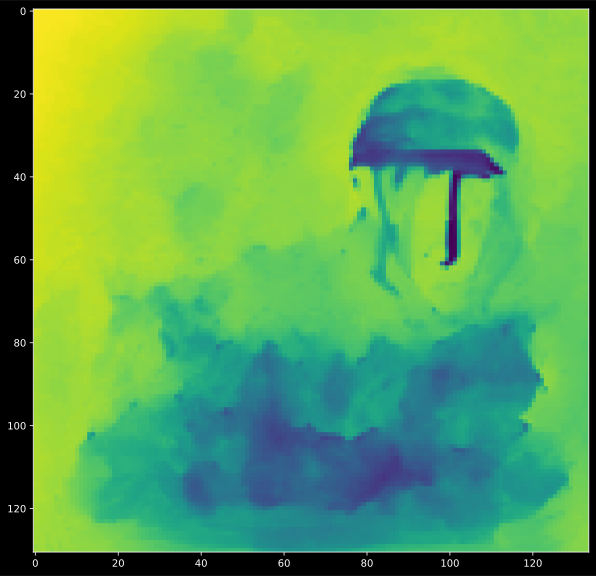

In [184]:
f,ax = plt.subplots(figsize=(10,10))
ax.imshow(filt_img)

In [185]:
prms = []
for ii, row in enumerate(filt_img):
    for jj, intensity in enumerate(row):
        x = np.interp(jj, (0, filt_img.shape[1]), (db.left, db.right))
        y = np.interp(ii, (0, filt_img.shape[0]), (db.bottom, db.top))
        pt = Point(x, y)
        
        prm = {
            'geometry':pt,
            'x':x,
            'y':y,
            'ii':ii,
            'jj':jj,
            'intensity': intensity,
        }
        prms.append(prm)
geodf = geopandas.GeoDataFrame(prms)

In [186]:
x_spacing = geodf['x'].diff().dropna().median()
y_spacing = geodf['y'].diff().dropna().median()
pix_spacing = np.max((x_spacing, y_spacing))

In [187]:
pix_spacing

1.7865671641791039

In [197]:
max_intensity = 175
geodf['radius'] = np.interp(geodf.intensity, (0, max_intensity), (pix_spacing*0.9, 0))
geodf['rotation'] = np.interp(geodf.intensity, (0, max_intensity), (np.pi*4, 0))
geodf['fill_spacing'] = np.interp(geodf.intensity, (0, max_intensity), (-0.15, -0.35))

In [198]:
polys = []
fills = []
for ii, row in geodf.query('intensity < @max_intensity').iterrows():
    poly = gp.RegPolygon(
        row['geometry'],
        radius = x_spacing*0.7,
        n_corners=4,
        rotation=45
    )
    p = gp.Poly(poly.poly)

    prms = gp.ScaleTransPrms(
        n_iters=200,
        d_buffer=row['fill_spacing'],
        d_translate_factor=0.4,
        angles=row['rotation'],
    )
    p.fill_scale_trans(**prms.prms)
    polys.append(p.p)
    fills.append(p.fill)

In [199]:
fills = gp.merge_LineStrings(fills)

In [200]:
# fills = gp.make_like(fills, drawbox)

In [201]:
sk = vsketch.Vsketch()
sk.size(paper.page_format_mm)
sk.scale('1mm')
sk.penWidth('0.3mm')

sk.geometry(fills)

# counter = 0
# for ls in lss:
#     counter += 1
#     sk.stroke(counter)
#     sk.geometry(ls)
    
sk.display(color_mode='layer')

<?xml version="1.0" encoding="utf-8" ?>
 
 
 
 
 image/svg+xml 
 
 2021-11-06T16:29:36.701685 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 

In [202]:
sk.vpype('splitall linemerge linesort')

In [203]:
plot_id = fn.new_plot_id()

saved 20211106-163042_056783-b365a-4ad3e5 to s3://algorithmic-ink/current_plot_id


In [204]:
savedir='/home/naka/art/plotter_svgs'

In [205]:
savepath = Path(savedir).joinpath(f'{plot_id}.svg').as_posix()
sk.save(savepath)

In [ ]:
# make page
paper_size = '14x17 inches'
border:float=30
paper = Paper(paper_size)

drawbox = paper.get_drawbox(border)

In [ ]:
step_size = 6

In [ ]:
(xbins, ybins), (xs, ys) = gp.overlay_grid(poly=drawbox, xstep=step_size, ystep=step_size, flatmesh=True)

In [ ]:
pts = [Point(x, y) for x,y in zip(xs, ys)]

In [ ]:
T_x = 0.045
T_y = 0.33
radius = 3.3

In [ ]:
prms = []
for ii, pt in enumerate(pts):
    intensity = np.cos(T_x * pt.x) + np.sin(T_y * pt.y**0.5)
    
    prm = {
        'geometry':pt,
        'intensity': intensity,
    }
    prms.append(prm)
geodf = geopandas.GeoDataFrame(prms)

In [ ]:
geodf['radius'] = np.interp(geodf.intensity, (-2, 2), (radius, radius))
geodf['rotation'] = np.interp(geodf.intensity, (-2, 2), (np.pi*4, 0))
geodf['fill_spacing'] = np.interp(geodf.intensity, (-2, 2), (-0.5, -1.4))

In [ ]:
polys = []
fills = []
for ii, row in geodf.iterrows():
    poly = gp.RegPolygon(
        row['geometry'],
        radius = row['radius'],
        n_corners=4,
        rotation=45
    )
    p = gp.Poly(poly.poly)

    prms = gp.ScaleTransPrms(
        n_iters=200,
        d_buffer=row['fill_spacing'],
        d_translate_factor=0.8,
        angles=row['rotation'],
    )
    p.fill_scale_trans(**prms.prms)
    polys.append(p.p)
    fills.append(p.fill)

In [ ]:
fills = gp.merge_LineStrings(fills)

In [ ]:
fills = gp.make_like(fills, drawbox)

In [ ]:
sk = vsketch.Vsketch()
sk.size(paper.page_format_mm)
sk.scale('1mm')
sk.penWidth('0.3mm')

sk.geometry(fills)

# counter = 0
# for ls in lss:
#     counter += 1
#     sk.stroke(counter)
#     sk.geometry(ls)
    
sk.display(color_mode='layer')

In [ ]:
sk.vpype('splitall linemerge linesort')

In [ ]:
plot_id = fn.new_plot_id()

In [ ]:
savedir='/home/naka/art/plotter_svgs'

In [ ]:
savepath = Path(savedir).joinpath(f'{plot_id}.svg').as_posix()
sk.save(savepath)

# postcard

In [ ]:
image_path= '/home/naka/art/vqgan_clip/20210816_014617_books_rising_out_of_the_watervray_unreal_engine_style0091.png'
paper_size = '14x11 inches'
border:float=10
image_rescale_factor:float=0.5
smooth_disk_size:int=0
hist_clip_limit=0.1
hist_nbins=32
intensity_min=0.
intensity_max=1.
hatch_spacing_min=0.6  # mm
hatch_spacing_max=1.5 # mm
pixel_width=1 # mm
pixel_height=1 # mm
angle_jitter='0'  # degrees
pixel_rotation='0'  # degrees
merge_tolerances=[0.5, 0.8, 1.2]  # mm
simplify_tolerances=[0.2, 0.4]  # mm
savedir='/home/naka/art/plotter_svgs'

In [ ]:
# make page
paper = Paper(paper_size)
drawbox = paper.get_drawbox(border)
db = gp.Poly(drawbox)
# load
# img =  io.imread(Path(image_path))

In [ ]:
img =  rgb2gray(io.imread(Path(image_path)))
img_rescale = rescale(img, image_rescale_factor)

In [ ]:

        
# 
# img_renorm = exposure.equalize_adapthist(img_rescale, clip_limit=hist_clip_limit, nbins=hist_nbins)
img_renorm = img_rescale

In [ ]:
# calc dominant angle
selem = disk(smooth_disk_size)
filt_img = filters.rank.mean(img_renorm, selem)

In [ ]:
f,ax = plt.subplots(figsize=(10,10))
ax.imshow(filt_img)

In [ ]:
prms = []
for ii, row in enumerate(filt_img):
    for jj, intensity in enumerate(row):
        x = np.interp(jj, (0, filt_img.shape[1]), (db.left, db.right))
        y = np.interp(ii, (0, filt_img.shape[0]), (db.bottom, db.top))
        pt = Point(x, y)
        
        prm = {
            'geometry':pt,
            'x':x,
            'y':y,
            'ii':ii,
            'jj':jj,
            'intensity': intensity,
        }
        prms.append(prm)
geodf = geopandas.GeoDataFrame(prms)

In [ ]:
x_spacing = geodf['x'].diff().dropna().median()
y_spacing = geodf['y'].diff().dropna().median()
pix_spacing = np.max((x_spacing, y_spacing))
print(pix_spacing)

In [ ]:
geodf['radius'] = np.interp(geodf.intensity, (0, 255), (pix_spacing*0.9, 0))
geodf['rotation'] = np.interp(geodf.intensity, (0, 255), (np.pi*4, 0))
geodf['fill_spacing'] = np.interp(geodf.intensity, (0, 255), (-0.17, -0.65))

In [ ]:
polys = []
fills = []
for ii, row in geodf.iterrows():
    poly = gp.RegPolygon(
        row['geometry'],
        radius = x_spacing*0.7,
        n_corners=4,
        rotation=45
    )
    p = gp.Poly(poly.poly)

    prms = gp.ScaleTransPrms(
        n_iters=200,
        d_buffer=row['fill_spacing'],
        d_translate_factor=0.4,
        angles=row['rotation'],
    )
    p.fill_scale_trans(**prms.prms)
    polys.append(p.p)
    fills.append(p.fill)

In [ ]:
fills = gp.merge_LineStrings(fills)

In [ ]:
fills = gp.make_like(fills, drawbox)

In [ ]:
sk = vsketch.Vsketch()
sk.size(paper.page_format_mm)
sk.scale('1mm')
sk.penWidth('0.3mm')

sk.geometry(fills)

# counter = 0
# for ls in lss:
#     counter += 1
#     sk.stroke(counter)
#     sk.geometry(ls)
    
sk.display(color_mode='layer')

In [ ]:
sk.vpype('splitall linemerge linesort')

In [ ]:
plot_id = fn.new_plot_id()

In [ ]:
savedir='/home/naka/art/plotter_svgs'

In [ ]:
savepath = Path(savedir).joinpath(f'{plot_id}.svg').as_posix()
sk.save(savepath)

In [ ]:
11 * 14

# 

In [ ]:
11/14

In [ ]:
540 * 540

In [ ]:
540 * 0.78